In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline


Accelerating VQEs with quantum natural gradient
===============================================

.. meta::
    :property="og:description": Accelerating variational quantum eigensolvers
        using quantum natural gradients in PennyLane.
    :property="og:image": https://pennylane.ai/qml/_images/qng_example.png

.. related::

   tutorial_vqe Variational quantum eigensolver
   tutorial_quantum_natural_gradient Quantum natural gradient

*Authors: Maggie Li, Lana Bozanic, Sukin Sim (ssim@g.harvard.edu). Last updated: 8 Apr 2021.*

This tutorial showcases how one can apply quantum natural gradients (QNG) [#stokes2019]_ [#yamamoto2019]_
to accelerate the optimization step of the Variational Quantum Eigensolver (VQE) algorithm [#peruzzo2014]_.
We will implement two small examples: estimating the ground state energy of (1) a single-qubit VQE
problem, which we can visualize using the Bloch sphere, and (2) the hydrogen molecule.

Before going through this tutorial, we recommend that readers refer to the
:doc:`QNG tutorial </demos/tutorial_quantum_natural_gradient>` and
:doc:`VQE tutorial </demos/tutorial_vqe>` for overviews
of quantum natural gradient and the variational quantum eigensolver algorithm, respectively.
Let's get started!


(1) Single-qubit VQE example
----------------------------

The first step is to import the required libraries and packages:


In [112]:
import matplotlib.pyplot as plt
from pennylane import numpy as np
import pennylane as qml

For this simple example, we consider the following single-qubit Hamiltonian: $\sigma_x + \sigma_z$.

We define the device:



In [119]:
dev = qml.device("default.qubit", wires=3)

For the variational ansatz, we use two single-qubit rotations, which the user may recognize
from a previous :doc:`tutorial </demos/tutorial_qubit_rotation>` on qubit rotations.



In [120]:
def circuit_4(params,wires):
    t0 = params[0]
    t1 = params[1]
    t2 = params[2]
    qml.PauliX(wires=0)
    qml.RY(t2, wires=1)
    qml.RY(t1, wires=2)
    qml.RY(t0, wires=3)
    qml.CNOT(wires=[3,0])
    qml.CNOT(wires=[0,2])
    qml.RY(-t1, wires=2)
    qml.CNOT(wires=[0,2])
    qml.CNOT(wires=[2,0])
    #qml.CNOT(wires=[1,0])
    qml.CNOT(wires=[0,1])
    qml.RY(-t1, wires=2)
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[1,0])
def circuit_3(params,wires):
    t0 = params[0]
    t1 = params[1]
    qml.PauliX(wires=0)
    qml.RY(t1, wires=1)
    qml.RY(t0, wires=2)
    qml.CNOT(wires=[2,0])
    qml.CNOT(wires=[0,1])
    qml.RY(-t1, wires=1)
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[1,0])


We then define our cost function using the ``ExpvalCost`` class, which supports the computation of
block-diagonal or diagonal approximations to the Fubini-Study metric tensor [#stokes2019]_. This tensor is a
crucial component for optimizing with quantum natural gradients.



In [ ]:
coeffs = [1, 1]
obs = [qml.PauliX(0), qml.PauliZ(0)]
coeffs = [15.531709 ,-2.1433, -2.1433, 0.21829, -6.125, -9.625, -3.91, -3.91]
obs = [qml.Identity(0),qml.PauliX(0) @ qml.PauliX(1), qml.PauliY(0) @ qml.PauliY(1),qml.PauliZ(0),qml.PauliZ(1),qml.PauliZ(2),qml.PauliX(1) @ qml.PauliX(2),qml.PauliY(1) @ qml.PauliY(2)]

H = qml.Hamiltonian(coeffs, obs)
cost_fn = qml.ExpvalCost(circuit, H, dev)
print(H)

In [146]:
def kron(i,j):
    if(i==j):
        return 1
    else:
        return 0

def matrix_element(i,j):
    
    ele = 0.0
    
    ele = ((2.0*i + 1.5)*kron(i,j) - np.sqrt(i*(i+0.5))*kron(i,j+1) \
    - np.sqrt((i+1)*(i+1.5))*kron(i,j-1)) * 3.5
    
    ele += -5.68658111 * kron(i,0) * kron(i,j)
    
    
    return ele

def pauli_token_to_operator(token):
    """
    DO NOT MODIFY anything in this function! It is used to judge your solution.

    Helper function to turn strings into qml operators.

    Args:
        token (str): A Pauli operator input in string form.

    Returns:
        A qml.Operator instance of the Pauli.
    """
    qubit_terms = []

    for term in range(len(token)):
        # Special case of identity
        if token[term] == "I":
            pass
        else:
            #pauli, qubit_idx = term, term
            if token[term] == "X":
                qubit_terms.append(qml.PauliX(int(term)))
            elif token[term] == "Y":
                qubit_terms.append(qml.PauliY(int(term)))
            elif token[term] == "Z":
                qubit_terms.append(qml.PauliZ(int(term)))
            else:
                print("Invalid input.")
    if(qubit_terms==[]):
            qubit_terms.append(qml.Identity(0))
    full_term = qubit_terms[0]
    for term in qubit_terms[1:]:
        full_term = full_term @ term

    return full_term


def parse_hamiltonian_input(input_data):
    """
    DO NOT MODIFY anything in this function! It is used to judge your solution.

    Turns the contents of the input file into a Hamiltonian.

    Args:
        filename(str): Name of the input file that contains the Hamiltonian.

    Returns:
        qml.Hamiltonian object of the Hamiltonian specified in the file.
    """
    # Get the input
    coeffs = []
    pauli_terms = []
    chunks = input_data.split("\n")
    # Go through line by line and build up the Hamiltonian
    for line in chunks:
        #line = line.strip()
        tokens = line.split(" ")
        # Parse coefficients
        sign, value = tokens[0][0], tokens[1]

        coeff = float(value)
        if sign == "-":
            coeff *= -1
        coeffs.append(coeff)

        # Parse Pauli component
        pauli = tokens[3]
        
        pauli_terms.append(pauli_token_to_operator(pauli))

    return qml.Hamiltonian(coeffs, pauli_terms)



In [147]:
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper

mapper = JordanWignerMapper()
#mapper = ParityMapper()

N = 3
op=0
for i in range(N):
    for j in range(N):
        op += matrix_element(i,j) * \
        FermionicOp([([("+", i),("-", j)], 1.0)])#,register_length=2)

    #op = 30.2*FermionicOp([("+",0),("-",4)],register_length=2)
#print(op)

hamstr = "+ "+str(mapper.map(second_q_op=op))

#qml.load(mapper.map(second_q_op=op),format='qiskit')

hamiltonian = parse_hamiltonian_input(hamstr)

print(hamiltonian)

cost_fn = qml.ExpvalCost(circuit_3, hamiltonian, dev)


  (-9.625) [Z0]
+ (-6.125) [Z1]
+ (0.21829055499999983) [Z2]
+ (15.531709445) [I0]
+ (-3.913118960624632) [Y0 Y1]
+ (-3.913118960624632) [X0 X1]
+ (-2.1433035249352805) [Y1 Y2]
+ (-2.1433035249352805) [X1 X2]


/home/kyle/.local/lib/python3.10/site-packages/pennylane/vqe/vqe.py:153: UserWarning: ExpvalCost is deprecated, use qml.expval() instead. For optimizing Hamiltonian measurements with measuring commuting terms in parallel, use the grouping_type keyword in qml.Hamiltonian.
  warnings.warn(


To analyze the performance of quantum natural gradient on VQE calculations,
we set up and execute optimizations using the ``GradientDescentOptimizer`` (which does not
utilize quantum gradients) and the ``QNGOptimizer`` that uses the block-diagonal approximation
to the metric tensor.

To perform a fair comparison, we fix the initial parameters for the two optimizers.



In [125]:
#init_params = np.array([3.97507603, 3.00854038])
init_params = np.array([2.5,4.5])

We will carry out each optimization over a maximum of 500 steps. As was done in the VQE
tutorial, we aim to reach a convergence tolerance of around $10^{-6}$.
We use a step size of 0.01.



In [151]:
max_iterations = 500
conv_tol = 1e-06
step_size = 0.01

First, we carry out the VQE optimization using the standard gradient descent method.



In [154]:
opt = qml.GradientDescentOptimizer(stepsize=step_size)

params = init_params

gd_param_history = [params]
gd_cost_history = []

for n in range(max_iterations):

    # Take step
    params, prev_energy = opt.step_and_cost(cost_fn, params)
    gd_param_history.append(params)
    gd_cost_history.append(prev_energy)

    energy = cost_fn(params)

    # Calculate difference between new and old energies
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} MeV,  Convergence parameter = {"
            ":.8f} MeV".format(n, energy, conv)
        )

    if conv <= conv_tol:
        break

print()
print("Final value of the energy = {:.8f} MeV".format(energy))
print("Number of iterations = ", n)

Iteration = 0,  Energy = 2.62754488 MeV,  Convergence parameter = 0.41528526 MeV
Iteration = 20,  Energy = -1.45759287 MeV,  Convergence parameter = 0.07290178 MeV
Iteration = 40,  Energy = -1.98314671 MeV,  Convergence parameter = 0.00676702 MeV
Iteration = 60,  Energy = -2.03668718 MeV,  Convergence parameter = 0.00089606 MeV
Iteration = 80,  Energy = -2.04435261 MeV,  Convergence parameter = 0.00013419 MeV
Iteration = 100,  Energy = -2.04548435 MeV,  Convergence parameter = 0.00001928 MeV
Iteration = 120,  Energy = -2.04564498 MeV,  Convergence parameter = 0.00000269 MeV

Final value of the energy = -2.04566218 MeV
Number of iterations =  131


We then repeat the process for the optimizer employing quantum natural gradients:



In [152]:
opt = qml.QNGOptimizer(stepsize=step_size)

params = init_params

qngd_param_history = [params]
qngd_cost_history = []

for n in range(max_iterations):

    # Take step
    params, prev_energy = opt.step_and_cost(cost_fn, params)
    qngd_param_history.append(params)
    qngd_cost_history.append(prev_energy)

    # Compute energy
    energy = cost_fn(params)

    # Calculate difference between new and old energies
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} MeV,  Convergence parameter = {"
            ":.8f} MeV".format(n, energy, conv)
        )

    if conv <= conv_tol:
        break

print()
print("Final value of the energy = {:.8f} MeV".format(energy))
print("Number of iterations = ", n)

Iteration = 0,  Energy = 1.49924499 MeV,  Convergence parameter = 1.54358516 MeV
Iteration = 20,  Energy = -2.04299636 MeV,  Convergence parameter = 0.00076858 MeV
Iteration = 40,  Energy = -2.04565644 MeV,  Convergence parameter = 0.00000439 MeV

Final value of the energy = -2.04566796 MeV
Number of iterations =  46


Visualizing the results
^^^^^^^^^^^^^^^^^^^^^^^

For single-qubit examples, we can visualize the optimization process in several ways.

For example, we can track the energy history:



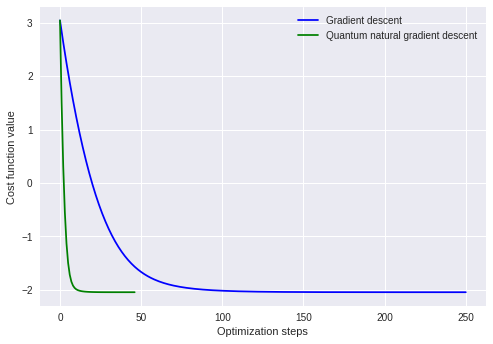

In [153]:
plt.style.use("seaborn")
plt.plot(gd_cost_history, "b", label="Gradient descent")
plt.plot(qngd_cost_history, "g", label="Quantum natural gradient descent")

plt.ylabel("Cost function value")
plt.xlabel("Optimization steps")
plt.legend()
plt.show()

Or we can visualize the optimization path in the parameter space using a contour plot.
Energies at different grid points have been pre-computed, and they can be downloaded by
clicking :download:`here<../demonstrations/vqe_qng/param_landscape.npy>`.



In [82]:
def gen_surface(theta0,theta1,cost_fn):
    parameter_landscape = np.zeros((theta0.shape[0],theta1.shape[0]))
    for i in range(theta0.shape[0]):
        parameter_landscape[i,:] = cost_fn([theta0[i],theta1[:]])
        #for j in range(theta1.shape[0]):
        #    parameter_landscape[i,j] = cost_fn([theta0[i],theta1[j]])
    return parameter_landscape

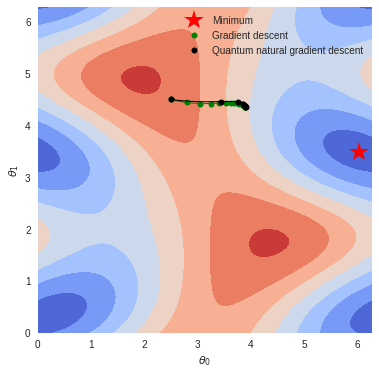

In [140]:
# Discretize the parameter space
theta0 = np.linspace(0.0, 2.0 * np.pi, 100)
theta1 = np.linspace(0.0, 2.0 * np.pi, 100)
#print(cost_fn([theta0[40],theta1[:]]))
#parameter_landscape = gen_surface(theta0, theta1, cost_fn)
# Load energy value at each point in parameter space
#parameter_landscape = np.load("param_landscape.npy")
#parameter_landscape_old = np.load("param_landscape.npy")
#np.save("deut_pes.npy", parameter_landscape)
parameter_landscape = np.load("deut_pes.npy")
minloc=np.unravel_index(parameter_landscape.argmin(),parameter_landscape.shape)
#parameter_landscape = np.zeros(parameter_landscape_old.shape)
#print(parameter_landscape_old.shape)
#for i in range(theta0.shape[0]):
#    for j in range(theta1.shape[0]):
#        parameter_landscape[i,j] = cost_fn([theta0[i],theta1[j]])
    
# Plot energy landscape
fig, axes = plt.subplots(figsize=(6, 6))
cmap = plt.cm.get_cmap("coolwarm")
contour_plot = plt.contourf(theta0, theta1, parameter_landscape.T, cmap=cmap)
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
plt.plot(theta0[minloc[0]],theta1[minloc[1]],"r*",markersize=20,label="Minimum")

# Plot optimization path for gradient descent. Plot every 10th point.
gd_color = "g"
plt.plot(
    np.array(gd_param_history)[::10, 0],
    np.array(gd_param_history)[::10, 1],
    ".",markersize=12,
    color=gd_color,
    linewidth=2,
    label="Gradient descent",
)
plt.plot(
    np.array(gd_param_history)[:, 0],
    np.array(gd_param_history)[:, 1],
    "-",
    color=gd_color,
    linewidth=1,
)
# Plot optimization path for quantum natural gradient descent. Plot every 10th point.
qngd_color = "k"
plt.plot(
    np.array(qngd_param_history)[::10, 0],
    np.array(qngd_param_history)[::10, 1],
    ".",markersize=12,
    color=qngd_color,
    linewidth=2,
    label="Quantum natural gradient descent",
)
plt.plot(
    np.array(qngd_param_history)[:, 0],
    np.array(qngd_param_history)[:, 1],
    "-",
    color=qngd_color,
    linewidth=1,
)

plt.legend()
plt.show()


Here, the red regions indicate states with lower energies, and the blue regions indicate
states with higher energies. We can see that the ``QNGOptimizer`` takes a more direct
route to the minimum in larger strides compared to the path taken by the ``GradientDescentOptimizer``.

Lastly, we can visualize the same optimization paths on the Bloch sphere using routines
from `QuTiP <http://qutip.org/>`__. The result should look like the following:

.. figure:: /demonstrations/vqe_qng/opt_paths_bloch.png
    :width: 50%
    :align: center

where again the black markers and line indicate the path taken by the ``QNGOptimizer``,
and the green markers and line indicate the path taken by the ``GradientDescentOptimizer``.
Using this visualization method, we can clearly see how the path using the ``QNGOptimizer`` tightly
"hugs" the curvature of the Bloch sphere and takes the shorter path.

Now, we will move onto a more interesting example: estimating the ground state energy
of molecular hydrogen.

(2) Hydrogen VQE Example
------------------------

To construct our system Hamiltonian, we first read the molecular geometry from
the external file :download:`h2.xyz </demonstrations/h2.xyz>` using the
:func:`~.pennylane_qchem.qchem.read_structure` function (see more details in the
:doc:`tutorial_quantum_chemistry` tutorial). The molecular Hamiltonian is then
built using the :func:`~.pennylane_qchem.qchem.molecular_hamiltonian` function.



In [75]:
#geo_file = "h2.xyz"

#symbols, coordinates = qml.qchem.read_structure(geo_file)
#hamiltonian, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates)

#15.531709 - 2.1433 X0X1 - "
#        "2.1433 Y0Y1 + .21829 Z0 - 6.125 Z1 - "
#        "9.625 Z2 - 3.91 X1 X2 - 3.91 Y1 Y2
        
coeffs = [15.531709 ,-2.1433, -2.1433, .21829, -6.125, -9.625, -3.91, -3.91]
obs = [qml.Identity(0)@qml.Identity(1),qml.PauliX(0) @ qml.PauliX(1), qml.PauliY(0) @ qml.PauliY(1),qml.PauliZ(0),qml.PauliZ(1),qml.PauliZ(2),qml.PauliX(1) @ qml.PauliX(2),qml.PauliY(1) @ qml.PauliY(2)]
#coeffs = [-2.1433, -2.1433, .21829, -6.125, -9.625, -3.91, -3.91]
#obs = [qml.PauliX(0) @ qml.PauliX(1), qml.PauliY(0) @ qml.PauliY(1),qml.PauliZ(0),qml.PauliZ(1),qml.PauliZ(2),qml.PauliX(1) @ qml.PauliX(2),qml.PauliY(1) @ qml.PauliY(2)]
H = qml.Hamiltonian(coeffs, obs)
hamiltonian=H
print(H)
qubits=3
#print("Number of qubits = ", qubits)

(15.531709) [I0 I1]
+ (-2.1433) [X0 X1]
+ (-2.1433) [Y0 Y1]
+ (0.21829) [Z0]
+ (-6.125) [Z1]
+ (-9.625) [Z2]
+ (-3.91) [X1 X2]
+ (-3.91) [Y1 Y2]


For our ansatz, we use the circuit from the
`VQE tutorial <https://pennylane.ai/qml/demos/tutorial_vqe.html>`__
but expand out the arbitrary single-qubit rotations to elementary
gates (RZ-RY-RZ).



In [76]:
dev = qml.device("default.qubit", wires=qubits)
hf_state = np.array([1, 1, 0, 0], requires_grad=False)
'''
def ansatz(params, wires=[0, 1, 2]):
    #qml.BasisState(hf_state, wires=wires)
    for i in wires:
        qml.RZ(params[3 * i], wires=i)
        qml.RY(params[3 * i + 1], wires=i)
        #qml.RZ(params[3 * i + 2], wires=i)
    qml.CNOT(wires=[2, 1])
    qml.CNOT(wires=[2, 0])
    #qml.CNOT(wires=[3, 1])
'''
def ansatz(params, wires=[0,1,2]):
    #for i in wires:
    qml.PauliX(0)
    qml.RY(params[0],wires=1)
    qml.RY(params[1],wires=2)
    qml.CNOT(wires=[2,0])
    qml.CNOT(wires=[0,1])
    qml.RY(-params[0],wires=1)
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[1,0])

#print(params)

Note that the qubit register has been initialized to $|1100\rangle$, which encodes for
the Hartree-Fock state of the hydrogen molecule described in the minimal basis.
Again, we define the cost function using the ``ExpvalCost`` class.



In [77]:
cost = qml.ExpvalCost(ansatz, hamiltonian, dev, diff_method="parameter-shift")

For this problem, we can compute the exact value of the
ground state energy via exact diagonalization. We provide the value below.



In [78]:
exact_value = -2.22

We now set up our optimizations runs.



In [92]:
np.random.seed(0)
init_params = np.random.uniform(low=0, high=2 * np.pi, size=3)#(qubits-1))
max_iterations = 500
step_size = 0.01
conv_tol = 1e-09

As was done with our previous VQE example, we run the standard gradient descent
optimizer.



In [93]:
opt = qml.GradientDescentOptimizer(step_size)

params = init_params

gd_cost = []

for n in range(max_iterations):
    params, prev_energy = opt.step_and_cost(cost, params)
    gd_cost.append(prev_energy)

    energy = cost(params)
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha, C = {:.4e}".format(n, energy, conv)
        )

    if conv <= conv_tol:
        break


print()
print("Final convergence parameter = {:.8f} Ha".format(conv))
print("Number of iterations = ", n)
print("Final value of the ground-state energy = {:.8f} Ha".format(energy))
print(
    "Accuracy with respect to the FCI energy: {:.8f} Ha ({:.8f} kcal/mol)".format(
        np.abs(energy - exact_value), np.abs(energy - exact_value) 
    )
)
print()
print("Final circuit parameters = \n", params)

Iteration = 0,  Energy = 7.08874905 Ha, C = 1.6357e+00
Iteration = 20,  Energy = -1.72667384 Ha, C = 5.9942e-02
Iteration = 40,  Energy = -2.03551209 Ha, C = 1.8440e-03
Iteration = 60,  Energy = -2.04482410 Ha, C = 5.4870e-05
Iteration = 80,  Energy = -2.04510127 Ha, C = 1.6346e-06
Iteration = 100,  Energy = -2.04510953 Ha, C = 4.8713e-08
Iteration = 120,  Energy = -2.04510978 Ha, C = 1.4519e-09

Final convergence parameter = 0.00000000 Ha
Number of iterations =  123
Final value of the ground-state energy = -2.04510978 Ha
Accuracy with respect to the FCI energy: 0.17489022 Ha (0.17489022 kcal/mol)

Final circuit parameters = 
 [3.50058904 6.02654419 3.78727399]


Next, we run the optimizer employing quantum natural gradients.



In [94]:
opt = qml.QNGOptimizer(step_size, lam=0.001, diag_approx=False)

params = init_params
prev_energy = cost(params)
qngd_cost = []

for n in range(max_iterations):
    params, prev_energy = opt.step_and_cost(cost, params)
    qngd_cost.append(prev_energy)

    energy = cost(params)
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha".format(n, energy)
        )

    if conv <= conv_tol:
        break


print("\nFinal convergence parameter = {:.8f} Ha".format(conv))
print("Number of iterations = ", n)
print("Final value of the ground-state energy = {:.8f} Ha".format(energy))
print(
    "Accuracy with respect to the FCI energy: {:.8f} Ha ({:.8f} kcal/mol)".format(
        np.abs(energy - exact_value), np.abs(energy - exact_value) * 627.503
    )
)
print()
print("Final circuit parameters = \n", params)

Iteration = 0,  Energy = 3.07502059 Ha
Iteration = 20,  Energy = -2.04510918 Ha

Final convergence parameter = 0.00000000 Ha
Number of iterations =  29
Final value of the ground-state energy = -2.04510979 Ha
Accuracy with respect to the FCI energy: 0.17489021 Ha (109.74413458 kcal/mol)

Final circuit parameters = 
 [3.50058187 6.02656594 3.78727399]


Visualizing the results
^^^^^^^^^^^^^^^^^^^^^^^

To evaluate the performance of our two optimizers, we can compare: (a) the
number of steps it takes to reach our ground state estimate and (b) the quality of our ground
state estimate by comparing the final optimization energy to the exact value.



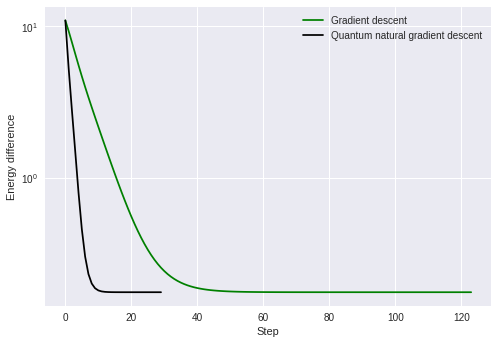

In [95]:
plt.style.use("seaborn")
plt.plot(np.array(gd_cost) - exact_value, "g", label="Gradient descent")
plt.plot(np.array(qngd_cost) - exact_value, "k", label="Quantum natural gradient descent")
plt.yscale("log")
plt.ylabel("Energy difference")
plt.xlabel("Step")
plt.legend()
plt.show()

We see that by employing quantum natural gradients, it takes fewer steps
to reach a ground state estimate and the optimized energy achieved by
the optimizer is lower than that obtained using vanilla gradient descent.




Robustness in parameter initialization
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

While results above show a more rapid convergence for quantum natural gradients,
what if we were just lucky, i.e., we started at a "good" point in parameter space?
How do we know this will be the case with high probability regardless of the
parameter initialization?

Using the same system Hamiltonian, ansatz, and device, we tested the robustness
of the ``QNGOptimizer`` by running 10 independent trials with random parameter initializations.
For this numerical test, our optimizer does not terminate based on energy improvement; we fix the number of
iterations to 200.
We show the result of this test below (after pre-computing), where we plot the mean and standard
deviation of the energies over optimization steps for quantum natural gradient and standard gradient descent.

.. figure:: ../demonstrations/vqe_qng/k_runs_.png
    :align: center
    :width: 60%
    :target: javascript:void(0)

We observe that quantum natural gradient on average converges faster for this system.

<div class="alert alert-info"><h4>Note</h4><p>While using QNG may help accelerate the VQE algorithm in terms of optimization steps,
    each QNG step is more costly than its vanilla gradient descent counterpart due to
    a greater number of calls to the quantum computer that are needed to compute the Fubini-Study metric tensor.</p></div>

While further benchmark studies are needed to better understand the advantages
of quantum natural gradient, preliminary studies such as this tutorial show the potentials
of the method. 🎉




References
--------------

.. [#stokes2019]

    Stokes, James, *et al.*, "Quantum Natural Gradient".
    `arXiv preprint arXiv:1909.02108 (2019).
    <https://arxiv.org/abs/1909.02108>`__

.. [#yamamoto2019]

    Yamamoto, Naoki, "On the natural gradient for variational quantum eigensolver".
    `arXiv preprint arXiv:1909.05074 (2019).
    <https://arxiv.org/abs/1909.05074>`__

.. [#peruzzo2014]

    Alberto Peruzzo, Jarrod McClean *et al.*, "A variational eigenvalue solver on a photonic
    quantum processor". `Nature Communications 5, 4213 (2014).
    <https://www.nature.com/articles/ncomms5213?origin=ppub>`__

